In [22]:
import pandas as pd
from thoughtfulness_features import *
import os
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize

# Read labelled data

In [4]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_labelled.csv'

# Create thoughtful comment features

In [3]:
df = pd.read_csv(file_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.head()

,Comment,Thoughtful?,Topic
0,Even watching the forbidden p0rn vids are ille...,0,Tracetogether
1,OP make a lot of claims without pointing out t...,0,Tracetogether
2,*pretends to be shocked*,0,Tracetogether
3,"Credit where credit is due, he clearly says Tr...",0,Tracetogether
4,got RTX 3080 anot??,0,Tracetogether


## Ceating Feature 1

In [5]:
# Creating feature 1 (Structural feature): comment length
comment_length = []
for row in df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
df['Length'] = comment_length

### Drop rows with comment length == 0

In [6]:
# Removing rows with zero comment length before creating features 2 to 5
df.drop(df[df.Length == 0].index, inplace=True)

# Creating Features 2 to 4

In [8]:
# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

df['Average Loglikelihood'] = comment_likelihood
df['Num Verbs'] = num_verbs
df['Num Discourse Relations'] = num_discourse_relations

In [10]:
df.head()

,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations
0,Even watching the forbidden p0rn vids are ille...,0,Tracetogether,28,-12.470231,6,1
1,OP make a lot of claims without pointing out t...,0,Tracetogether,27,-11.514518,6,1
2,*pretends to be shocked*,0,Tracetogether,4,-10.466185,2,0
3,"Credit where credit is due, he clearly says Tr...",0,Tracetogether,17,-11.904904,5,1
4,got RTX 3080 anot??,0,Tracetogether,4,-18.174303,1,0


# Creating Feature 5

### Reading all the policy docs into a corpus

In [38]:
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')

In [42]:
fid = corpus.fileids()
fid.sort()

In [43]:
doc_words = [corpus.words(f) for f in fid]

In [44]:
fid

['circuit_breaker_policy.txt',
 'safe_distancing_policy.txt',
 'tracetogether_policy.txt',
 'vaccination_policy.txt']

### Splitting the labelled data to its own policy/topic

In [45]:
circuit_breaker_comments = df[df['Topic'] == 'circuit breaker']
safe_distancing_comments = df[df['Topic'] == 'safe distancing']
tracetogether_comments = df[df['Topic'] == 'Tracetogether']
vaccination_comments = df[df['Topic'] == 'vaccination']
comments = [circuit_breaker_comments, safe_distancing_comments, tracetogether_comments, vaccination_comments, ]

### Calculating KL-divergence relevance score for each comment to its respective policy topic

In [46]:
for i in range(4):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

In [47]:
df_final = pd.concat(comments, ignore_index=True)

In [51]:
df_final.head()

,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,🇸🇬New Parc Clematis National Day Promo startin...,0,circuit breaker,34,-13.944796,4,1,0.394303
1,"Oh my fucking God, this announcement could not...",0,circuit breaker,94,-11.286315,16,5,0.305200
2,Dang it. I was super happy for a while.\n\nIt'...,0,circuit breaker,18,-9.626479,3,2,1.482839
3,After a beautiful front 9 we got hit with the ...,0,circuit breaker,11,-13.549426,2,0,0.811136
4,"these people must be tagged, if not cannot ent...",0,circuit breaker,11,-11.213937,2,1,1.674952


In [52]:
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

# Training the classification model

In [28]:
### Basic Imports
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 


### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

In [54]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

In [6]:
df.head()

,Unnamed: 0,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,0,🇸🇬New Parc Clematis National Day Promo startin...,0,circuit breaker,34,-13.944796,4,1,0.394303
1,1,"Oh my fucking God, this announcement could not...",0,circuit breaker,94,-11.286315,16,5,0.305200
2,2,Dang it. I was super happy for a while.\n\nIt'...,0,circuit breaker,18,-9.626479,3,2,1.482839
3,3,After a beautiful front 9 we got hit with the ...,0,circuit breaker,11,-13.549426,2,0,0.811136
4,4,"these people must be tagged, if not cannot ent...",0,circuit breaker,11,-11.213937,2,1,1.674952


In [55]:
features_list = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
target = 'Thoughtful?'

In [8]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

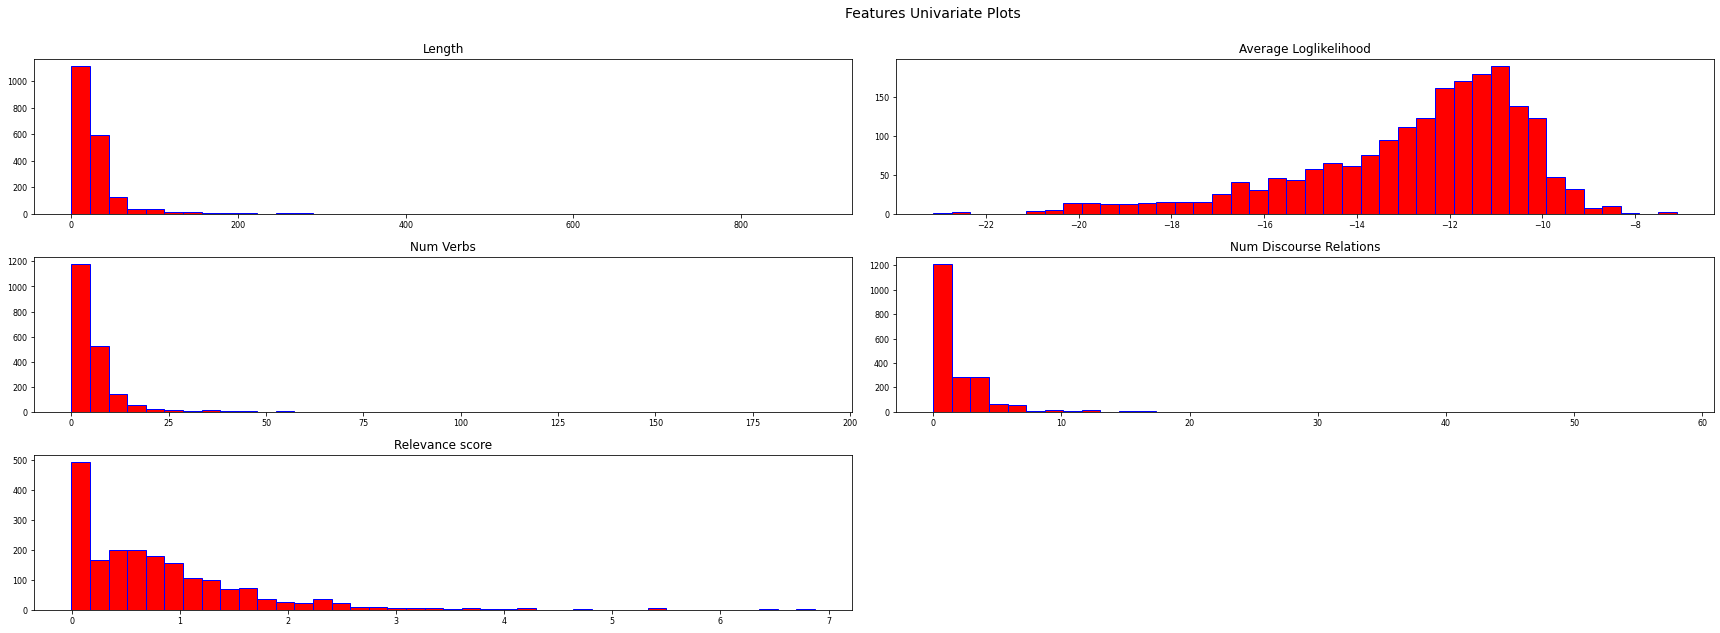

In [9]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

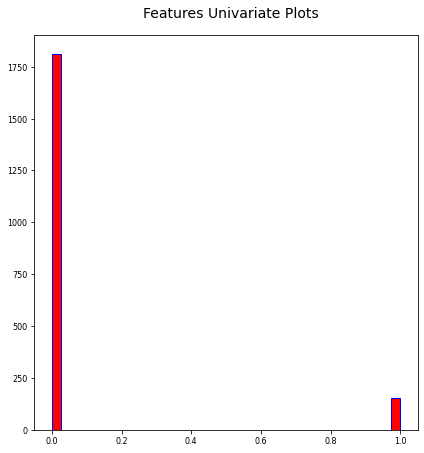

In [56]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

# Training of classficiation model

In [10]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

performance_data = {}

In [11]:
# Creating our independent and dependent variables df
x = df[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=15) 
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

model_acc_score = [] # store all the model acc scores 
performance_data = {
    'accuracy':[],
    'precision':[],
    'recall':[],
    'f1':[]
} # store acc, precision, recall, f1 score 

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    model_acc_score.append((model_name, acc))

    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    # adding into the performance data dict
    performance_data['accuracy'].append(acc)
    performance_data['precision'].append(precision)
    performance_data['recall'].append(recall)
    performance_data['f1'].append(f1)

    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))

Accuracy Score for Logistic Regression is 0.93039
Accuracy Score for Naive Bayes is 0.92699
Accuracy Score for Decision Trees is 0.89813
Accuracy Score for SVM linear is 0.92699
Accuracy Score for SVM rbf is 0.92530
Accuracy Score for Random Forest is 0.92869
[03:07:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score for XGBoost is 0.92020


# Stratified K-Fold Sampling

In [23]:
skf = StratifiedKFold(n_splits=10)
target = df['Thoughtful?']

In [24]:
fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:',
          sum(test['Thoughtful?'])/len(test['Thoughtful?']))
    fold_no += 1

Fold 1 Class Ratio: 0.08121827411167512
Fold 2 Class Ratio: 0.08121827411167512
Fold 3 Class Ratio: 0.08121827411167512
Fold 4 Class Ratio: 0.07653061224489796
Fold 5 Class Ratio: 0.07653061224489796
Fold 6 Class Ratio: 0.07653061224489796
Fold 7 Class Ratio: 0.07653061224489796
Fold 8 Class Ratio: 0.07653061224489796
Fold 9 Class Ratio: 0.07653061224489796
Fold 10 Class Ratio: 0.07653061224489796


In [51]:
skf = StratifiedKFold(n_splits=10)

X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

model = LogisticRegression()
best_acc = 0
best_train_set = []
best_test_set = []

fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    if accuracy_score(y_test,predictions) > best_acc:
        best_acc = accuracy_score(y_test,predictions)
        best_train_set = train
        best_test_set = test
    print('Fold', str(fold_no), 'Accuracy:', accuracy_score(y_test,predictions))

    fold_no += 1

Fold 1 Accuracy: 0.9289340101522843
Fold 2 Accuracy: 0.9137055837563451
Fold 3 Accuracy: 0.9238578680203046
Fold 4 Accuracy: 0.9540816326530612
Fold 5 Accuracy: 0.9744897959183674
Fold 6 Accuracy: 0.9489795918367347
Fold 7 Accuracy: 0.9183673469387755
Fold 8 Accuracy: 0.9183673469387755
Fold 9 Accuracy: 0.9285714285714286
Fold 10 Accuracy: 0.9336734693877551


## Model with highest accuracy

In [52]:
model = LogisticRegression()

X_train = best_train_set[X]
y_train = best_train_set[y]
X_test = best_test_set[X]
y_test = best_test_set[y]
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy_score(y_test,predictions)

0.9744897959183674